In [58]:
import pandas as pd
from textblob import TextBlob
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasketch import MinHash, MinHashLSH
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter



In [59]:
file_path = "../data/fake reviews dataset.csv"
df = pd.read_csv(file_path)

In [60]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [62]:
unique_catgory = df['category'].unique()
print(unique_catgory)

['Home_and_Kitchen_5' 'Sports_and_Outdoors_5' 'Electronics_5'
 'Movies_and_TV_5' 'Tools_and_Home_Improvement_5' 'Pet_Supplies_5'
 'Kindle_Store_5' 'Books_5' 'Toys_and_Games_5'
 'Clothing_Shoes_and_Jewelry_5']


In [63]:
df = df.rename(columns={'text_':'text'})
df['category']=df['category'].str.replace('_5','',regex=False)

In [64]:
df.isnull().sum()

category    0
rating      0
label       0
text        0
dtype: int64

In [65]:
df.duplicated().sum()

12

In [66]:
df.drop_duplicates()

,category,rating,label,text
0,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry,1.0,CG,I liked nothing about this dress. The only rea...


In [67]:
df['label_binary'] = df['label'].replace({'CG': 1, 'OR': 0})

In [68]:
nltk.download('stopwords')
nltk.download('punkt')

# Assuming df is your DataFrame and 'text' is the column with the reviews
# Define a function to preprocess and tokenize each review
def preprocess_review(text):
    # Lowercase, remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and convert to set to ensure unique words
    words = set(word for word in words if word not in stopwords.words('english'))
    return list(words)


df['processed_text'] = df['text'].apply(preprocess_review)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vedisingvars/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


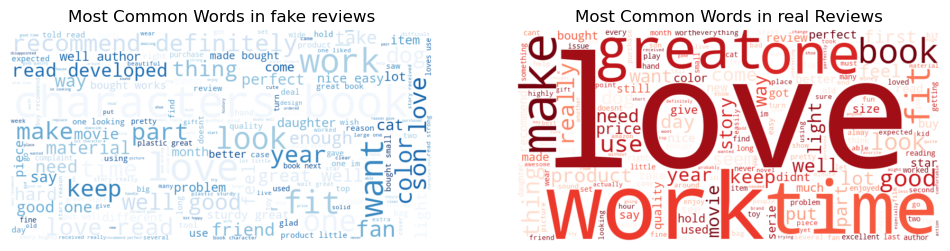

In [69]:
# Separate CG and OR reviews
cg_text = ' '.join([' '.join(words) for words in df[df['label'] == 'CG']['processed_text']])
or_text = ' '.join([' '.join(words) for words in df[df['label'] == 'OR']['processed_text']])

# Generate word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(cg_text)
plt.imshow(cg_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in fake reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
or_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(or_text)
plt.imshow(or_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in real Reviews')
plt.axis('off')

plt.show()

In [70]:
label_counts = df['label'].value_counts(normalize=True).reset_index()
label_counts.columns = ['label', 'proportion']

# Plot the proportions
fig = px.bar(label_counts, x='label', y='proportion', title='Count of OR and CG reviews',
             labels={'label': 'Label', 'proportion': 'Proportion'},
             color='label', color_discrete_sequence=['skyblue', 'salmon'])

fig.show()

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/vedisingvars/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



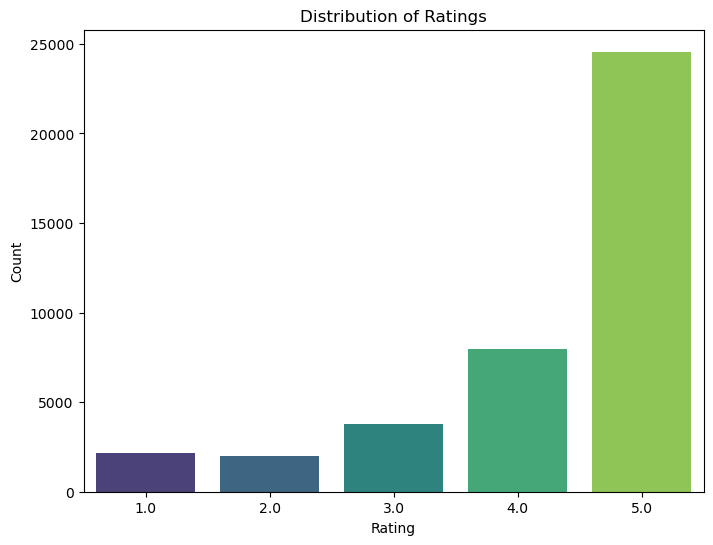

In [71]:

# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

/var/folders/9w/dgxmbyyn2hl1p64rjgpmgw880000gn/T/ipykernel_12895/1687703350.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




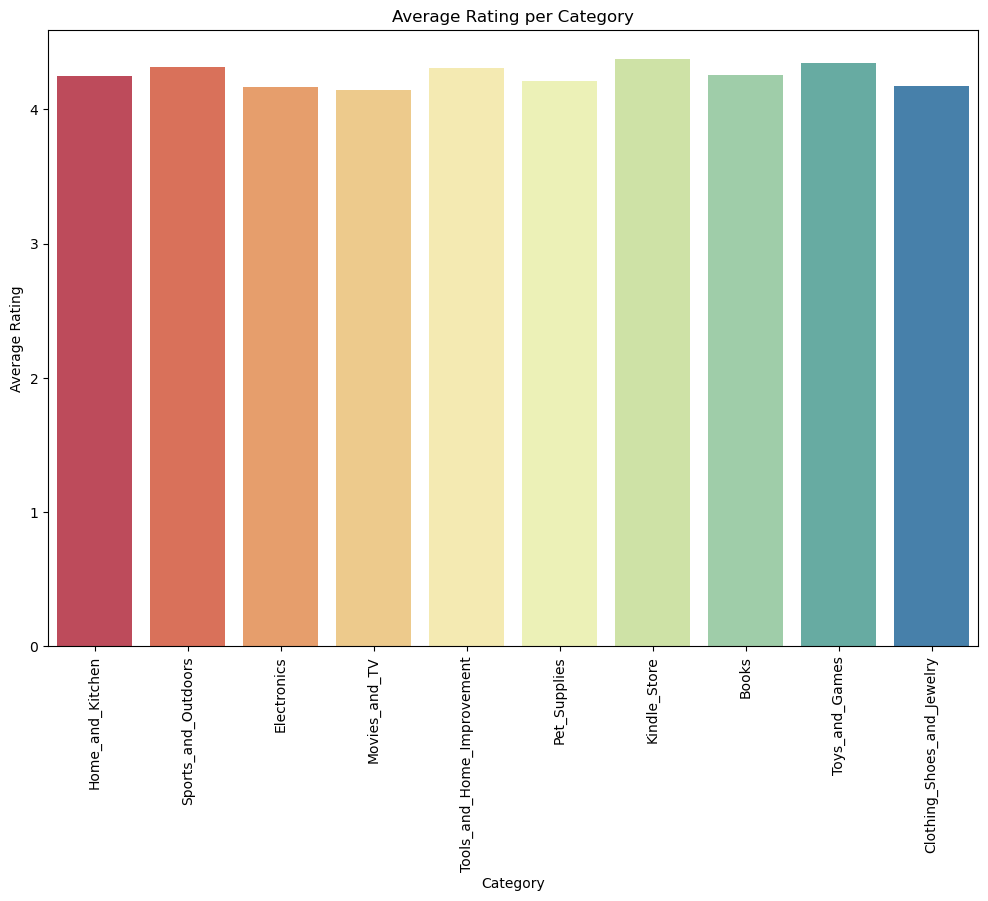

In [72]:
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='category', y='rating', estimator='mean', ci=None, palette='Spectral')
plt.xticks(rotation=90)
plt.title('Average Rating per Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.show()

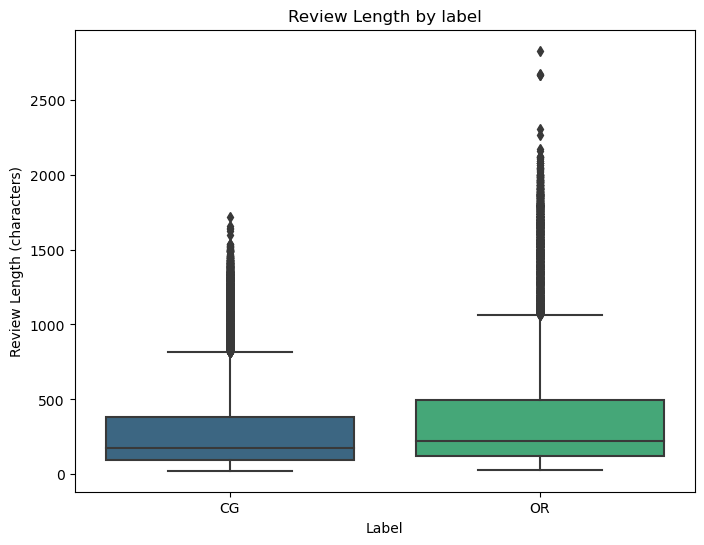

In [73]:
# Add a column for review length
df['review_length'] = df['text'].apply(len)

# Plot review length by rating
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='label', y='review_length', palette='viridis')
plt.title('Review Length by label')
plt.xlabel('Label')
plt.ylabel('Review Length (characters)')
plt.show()

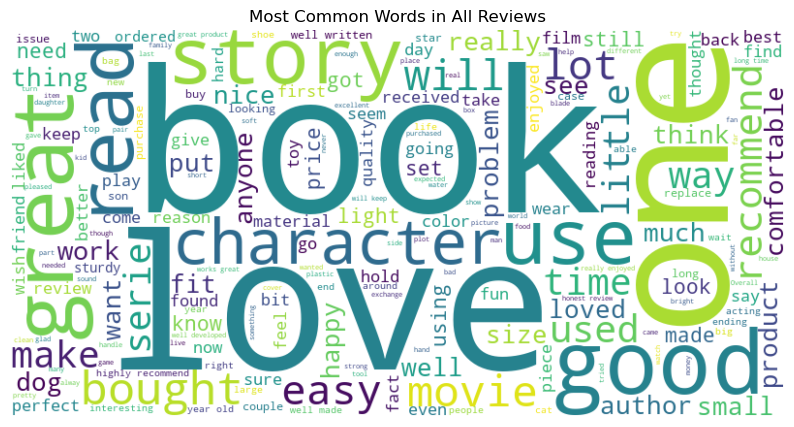

In [15]:
# Combine all text from the 'text' column into one string
all_text = ' '.join(df['text'].values)

# Generate the word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Common Words in All Reviews')
plt.axis('off')
plt.show()

In [74]:
# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Display the category with the most reviews
most_reviews_category = category_counts.idxmax()
most_reviews_count = category_counts.max()

print(f"Category with the most reviews: {most_reviews_category} ({most_reviews_count} reviews)")

Category with the most reviews: Kindle_Store (4730 reviews)


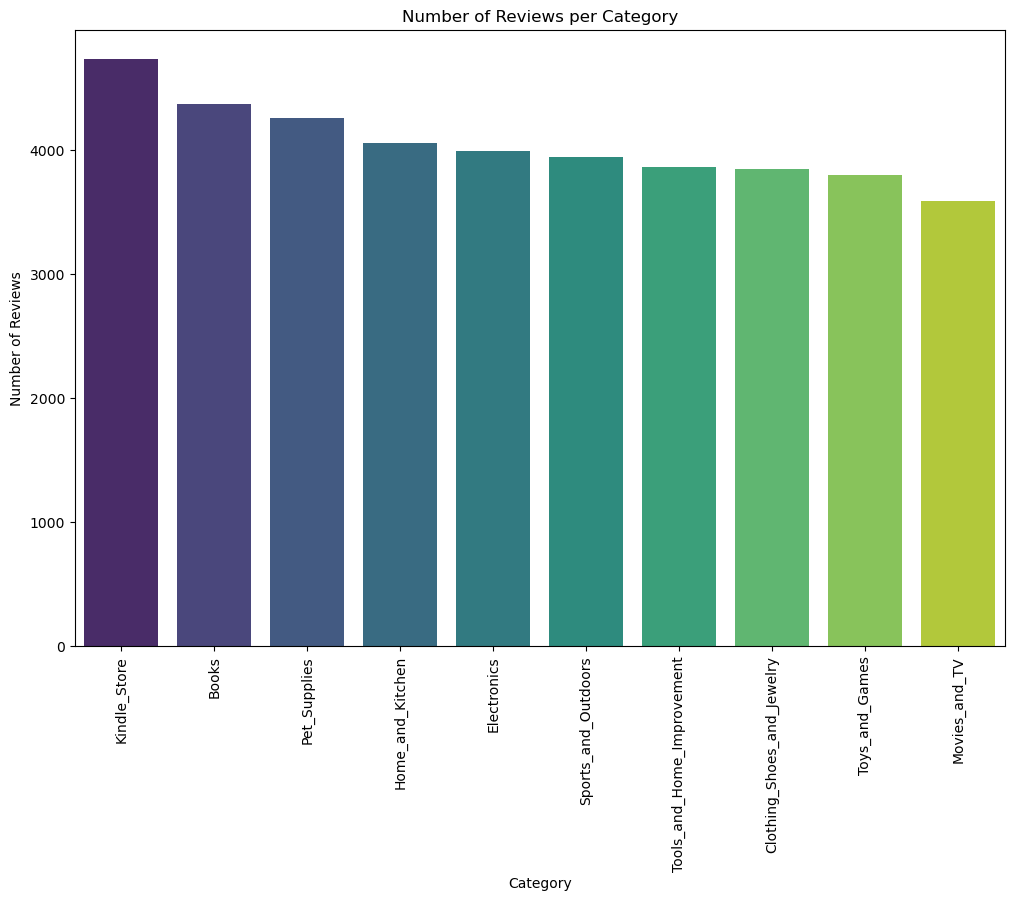

In [17]:
# Plot the number of reviews per category
plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Reviews per Category')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.show()

In [77]:
df2=df.copy()
df2['num_words'] = df2['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df2['num_sentences'] = df2['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df2.head()

,category,rating,label,text,label_binary,processed_text,review_length,num_words,num_sentences
0,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,"[comfortable, pretty, made, sturdy, itvery, lo...",75,18,3
1,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1,"[years, couple, ive, upgrade, mine, original, ...",80,19,2
2,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...,1,"[look, back, feel, pillow, love, saved]",67,16,2
3,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i...",1,"[great, product, missing, use, information, pr...",81,19,2
4,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1,"[nice, good, set, quality, two, months]",85,20,3


In [78]:
df2.describe()

,rating,label_binary,review_length,num_words,num_sentences
count,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000
mean,4.256579,0.500000,351.271963,76.670781,5.276143
std,1.144354,0.500006,369.813570,79.230096,4.914112
min,1.000000,0.000000,24.000000,2.000000,1.000000
25%,4.000000,0.000000,107.000000,24.000000,2.000000
50%,5.000000,0.500000,198.000000,44.000000,3.000000
75%,5.000000,1.000000,439.000000,96.000000,6.000000
max,5.000000,1.000000,2827.000000,510.000000,133.000000


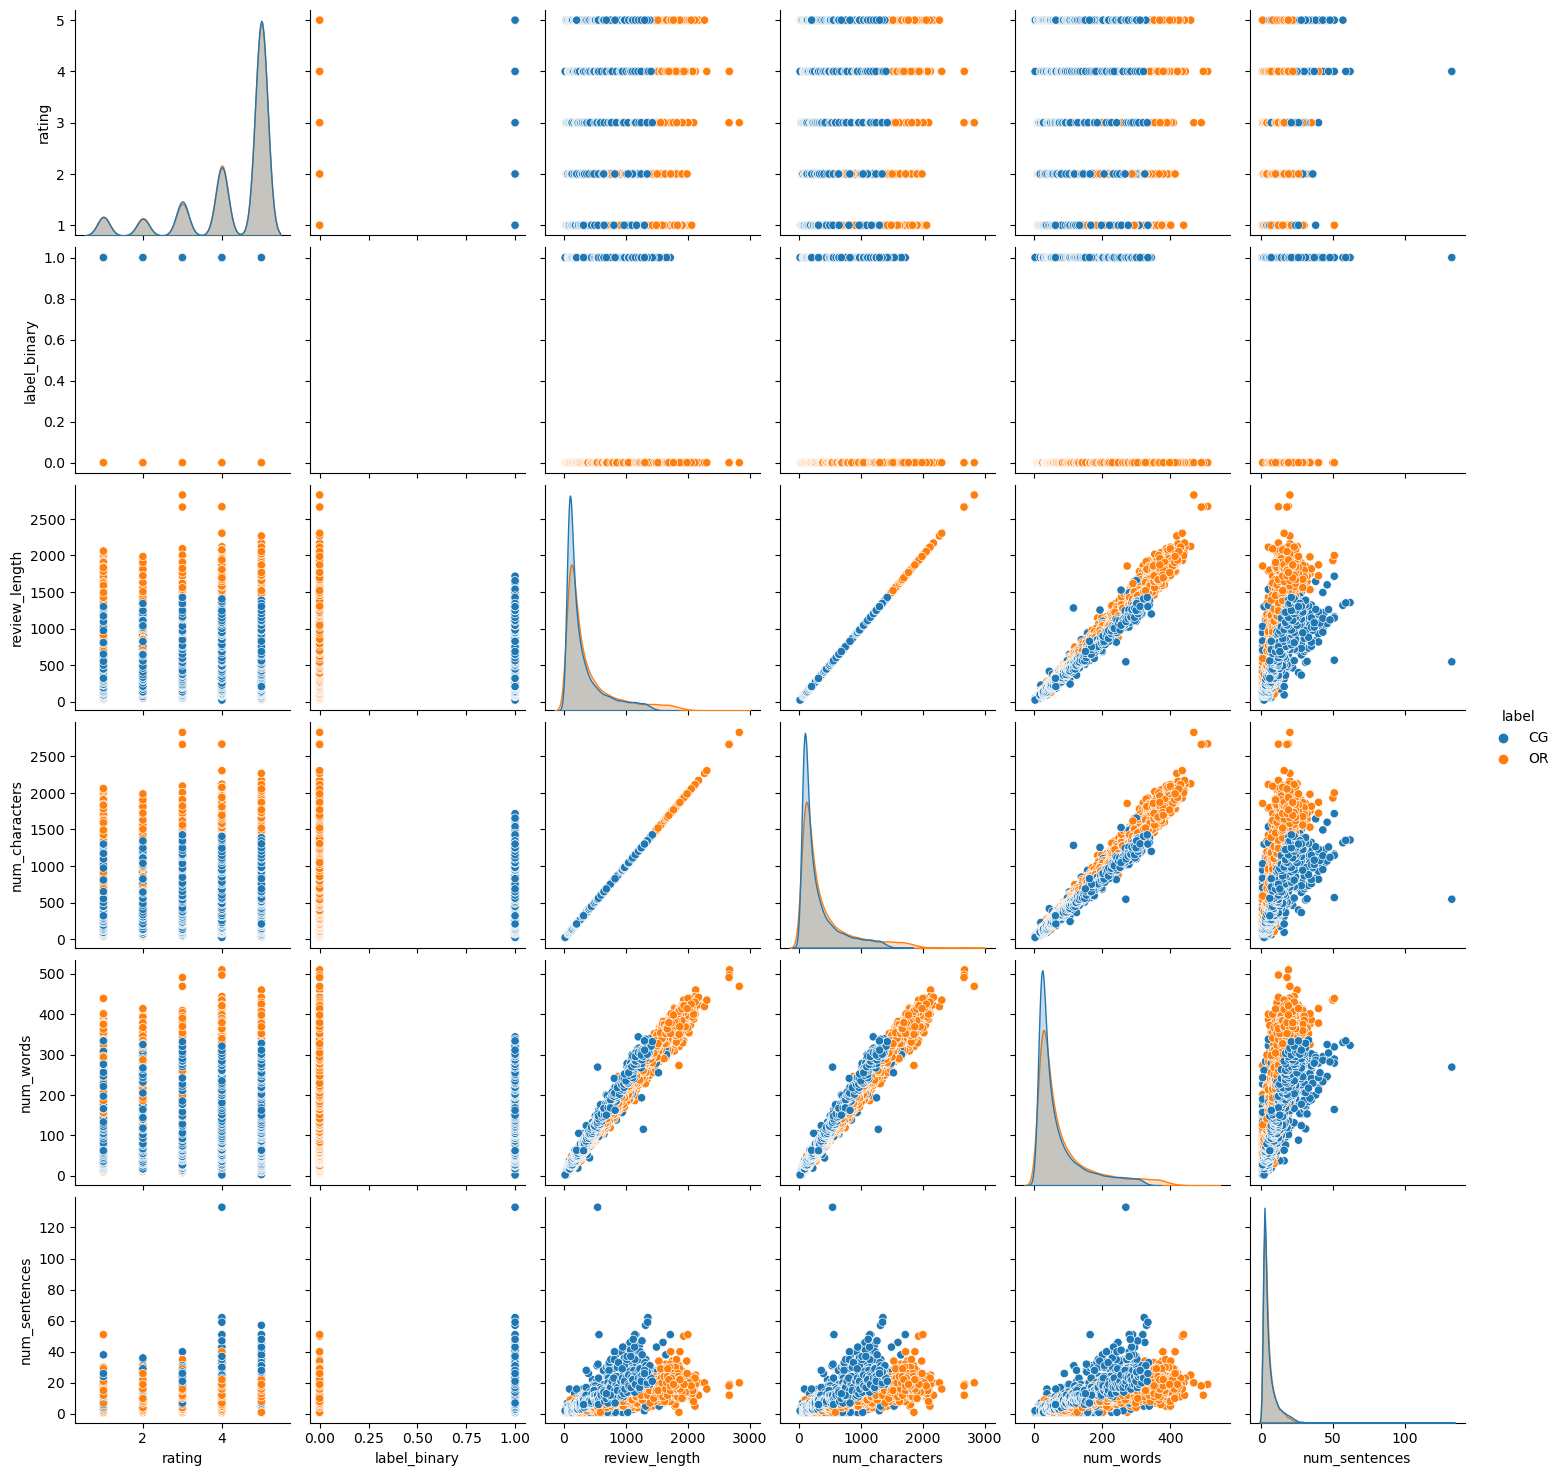

In [20]:
sns.pairplot(df,hue='label')

## Frequent items: apriori

In [54]:
te = TransactionEncoder()
te_ary = te.fit(df['processed_text']).transform(df['processed_text'])
df_one_hot = pd.DataFrame(te_ary, columns=te.columns_)
df_one_hot

,0,00,000,0005,00199,00200,0036in,0061849278,007,009,...,zulus,zuma,zumba,zumiez,zune,zuppies,zurg,zwave,zyliss,zymox
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40427,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40428,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40429,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40430,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Clustering

In [31]:
# Step 1: Preprocess the text data
# Convert to lowercase and remove punctuation
df['processed_text'] = df['text'].str.lower().str.replace('[^\w\s]', '', regex=True)


<>:3: DeprecationWarning:

invalid escape sequence '\w'

<>:3: DeprecationWarning:

invalid escape sequence '\w'

/var/folders/9w/dgxmbyyn2hl1p64rjgpmgw880000gn/T/ipykernel_12895/3764596705.py:3: DeprecationWarning:

invalid escape sequence '\w'



In [32]:
df.head(
)

,category,rating,label,text,label_binary,review_length,num_characters,num_words,num_sentences,processed_text
0,Home_and_Kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,75,75,18,3,love this well made sturdy and very comfortab...
1,Home_and_Kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1,80,80,19,2,love it a great upgrade from the original ive...
2,Home_and_Kitchen,5.0,CG,This pillow saved my back. I love the look and...,1,67,67,16,2,this pillow saved my back i love the look and ...
3,Home_and_Kitchen,1.0,CG,"Missing information on how to use it, but it i...",1,81,81,19,2,missing information on how to use it but it is...
4,Home_and_Kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1,85,85,20,3,very nice set good quality we have had the set...


In [34]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit features for simplicity
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

In [35]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

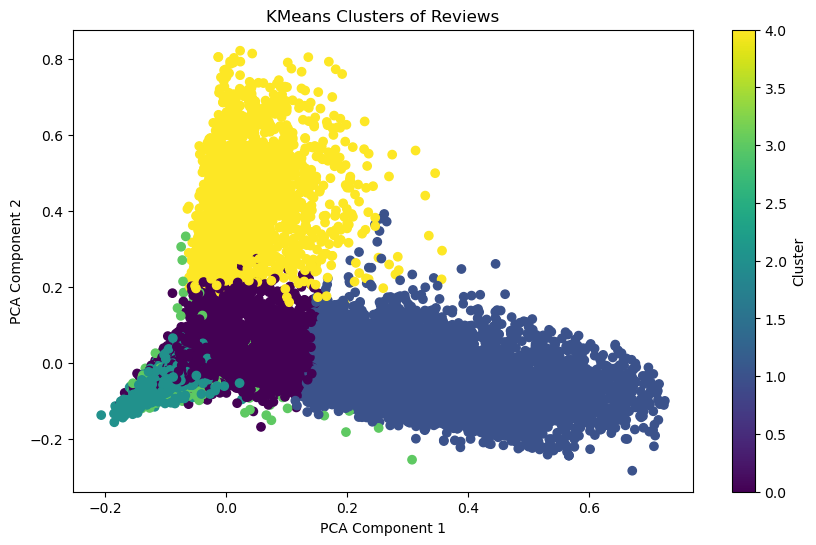

In [36]:
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=df['cluster'], cmap='viridis', marker='o')
plt.title('KMeans Clusters of Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()